## DEFINICIÓN DE CONSTANTES FUNDAMENTALES  

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Definir las constantes
g = 9.8 # gravedad [m/s^2]
p_atm = 101325 # Presión atmosférica [Pa]
beta = 3.67e-3 # Coeficiente de expansion termica [1/K]
T_w = 80.0 + 273.0 # Temperatura de la pared [K]
T_a = 20.0 + 273.0 # Temperatura ambiente [K]
delta_T = T_w - T_a
lambda_f = 0.04 # Coeficiente de friccion [adimensional]
R = 10.0 # Radio de la tuberia [m]
L = 100.0 # Longitud de la tuberia [m]
D = 2 * R
alpha = 2.2e-5 # Coeficiente de difusividad [m^2/s]
rho_0 = 1.0 # Densidad [kg/m^3]
Cp = 1.012 # Capacidad calorifica [J/(kg K)]
k = 0.024 # Conductividad termica [W/(m K)]
nu = 1.71e-5 # Viscosidad [Pa s]
Ra_D = (g * beta * delta_T * (2 * R)**3)/ nu**2 # Numero de Rayleigh
Nu = (576/(Ra_D * 2 * R /L)**2 + 2.873/(Ra_D * 2 * R /L)**(1/2))**(-1/2)# Numero de Nusselt
h_v = (k * Nu)/ (2 * R * L) # coeficiente de tranferencia de calor por convección [W/(m^3 K)]
h = 1.42 * (delta_T/L)**(1/4)

## DEFINICIÓN DE VALORES ADIMENSIONALES

In [3]:
phi = 1/ (beta * delta_T)
Ri = 2 * rho_0**2 * g * beta * L * Cp**2 * delta_T /  h**2 # Numero de Richardson
Ra = rho_0**2 * g * beta * Cp * D**2 * delta_T / (16 * nu * h) # Numero de Rayleigh
LAMBDA = L/D
delta = alpha * h / (L**2 * rho_0 * g * beta * Cp * delta_T)

## CALCULO DE v_0 POR NEWTON-RAPHSON

In [4]:
import math

def f(v, a, b, c, d):
    return a + b*v**2 + c*v - 1 + (v/d)*(1 - math.exp(-d/v))

def f_prime(v, b, c, d):
    return 2*b*v + c + (1/d)*(1 - math.exp(-d/v)) - (1/(d * v))*math.exp(-d/v)

def newton_raphson(a, b, c, d, v0, tol=1e-6, max_iter=100):
    v = v0
    for i in range(max_iter):
        v_new = v - f(v, a, b, c, d) / f_prime(v, b, c, d)
        if abs(v_new - v) < tol:
            return v_new, i+1
        v = v_new
    return v, max_iter  # Retorna la última aproximación si no converge

# Ejemplo de uso
a = phi
b = Ri**-1
c = Ra**-1
d = LAMBDA
v0 = 0.1  # Valor inicial

v_sol, iterations = newton_raphson(a, b, c, d, v0)
print(f"La solución aproximada es v_e = {v_sol:.6f}")
print(f"Número de iteraciones: {iterations}")

# Verificar la solución
residual = f(v_sol, a, b, c, d)
print(f"Residual: {residual:.2e}")

v_e = v_sol


La solución aproximada es v_e = 7.241852
Número de iteraciones: 100
Residual: 4.45e+00


## LA VELOCIDAD EN EL ESTACIONARIO SERÁ

In [5]:
u_e = v_e * h_v * L / (rho_0 * Cp)
print(f'u_e = {u_e:.2f} m/s o {u_e*3.6:.2f} km/h')

u_e = 9.39 m/s o 33.81 km/h


## DISTRIBUCIÓN DE TEMPERATURAS

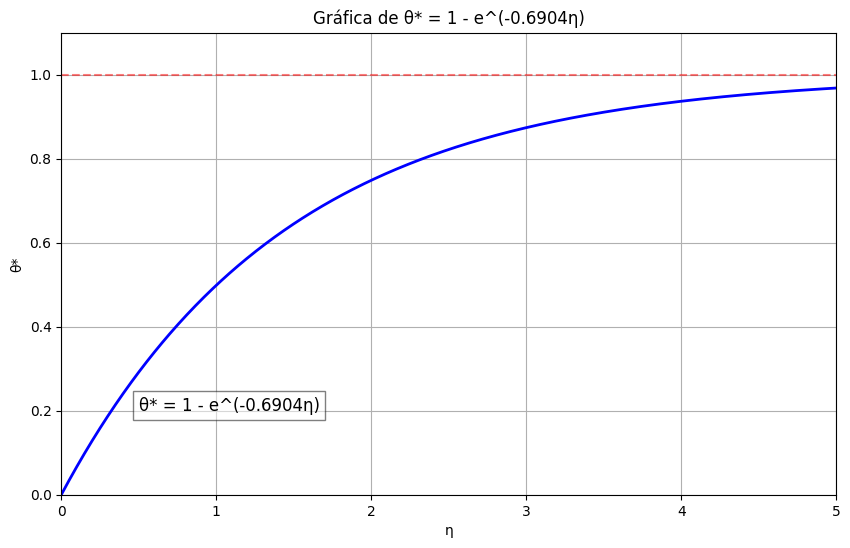

In [6]:
def theta_estrella(eta, a):
    return 1 - np.exp(-a * eta)

# Parámetros
a = h_v * L * LAMBDA / (rho_0 * Cp * u_e)  # Puedes cambiar este valor según tus necesidades

# Crear un rango de valores para eta
eta = np.linspace(0, 5, 1000)  # Ajusta el rango según sea necesario

# Calcular theta_estrella para cada valor de eta
theta = theta_estrella(eta, a)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(eta, theta, 'b-', linewidth=2)
plt.title(f'Gráfica de θ* = 1 - e^(-{a:.4f}η)')
plt.xlabel('η')
plt.ylabel('θ*')
plt.grid(True)
plt.axhline(y=1, color='r', linestyle='--', alpha=0.5)  # Línea asintótica en y=1
plt.xlim(0, max(eta))
plt.ylim(0, 1.1)

# Añadir una ecuación en la gráfica
plt.text(0.5, 0.2, f'θ* = 1 - e^(-{a:.4f}η)', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()


## SIMULACIÓN NUMÉRICA

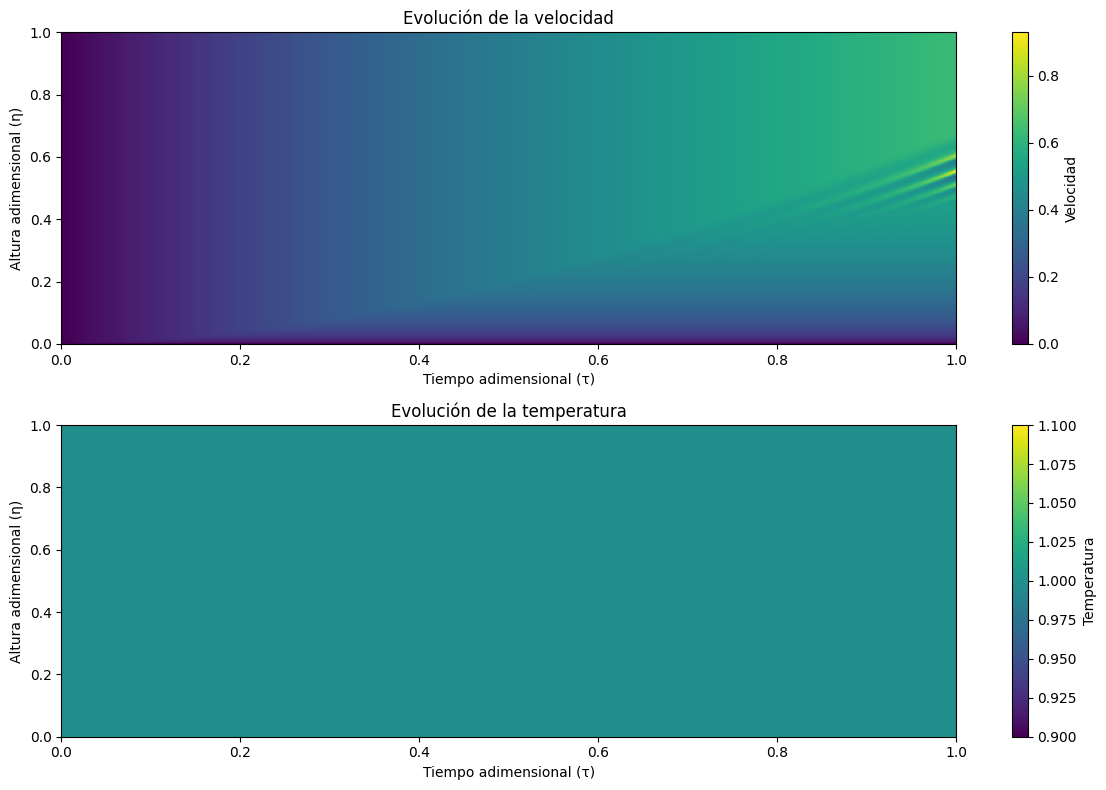

In [8]:
# Definición de variables y condiciones iniciales
M = 256  # Número de puntos en la dirección vertical
N = 512  # Número de puntos en la dirección temporal
eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
deta = (eta[-1] - eta[0]) / M
dtau = (tau[-1] - tau[0]) / N

v = np.zeros(N)  # Velocidad adimensional
theta_star = np.zeros((M, N))  # Temperatura adimensional
xi = np.zeros((M, N))  # Variable xi

# Parámetros físicos
Ra = 1.0  # Número de Rayleigh
Ri = 1.0  # Número de Richardson
delta = 0.1  # Parámetro de difusión
Lambda = 1.0  # Parámetro Lambda
v_e = 1.0  # Velocidad de escala
phi = 1.0  # Parámetro phi

# Condiciones iniciales
v[0] = 0.0  # Velocidad inicial cero
theta_star[:, 0] = 0.0  # Temperatura inicial uniforme
xi[:, 0] = 0.0  # xi inicial cero

# Simulación numérica
for t in range(1, N):
    # Calculo de xi
    xi[:, t] = Ri**-1 * phi**-1 * v_e**2 * v[:, t-1]**2
    
    # Calculo de v
    for x in range(1, M-1):
        dxi_deta = (xi[x+1, t] - xi[x-1, t]) / (2 * deta)
        v[x, t] = v[x, t-1] + dtau * (-phi/v_e * dxi_deta - Ra**-1 * v[x, t-1] + theta_star[x, t-1]/v_e)
    
    # Condiciones de contorno para v (puedes ajustar según tus necesidades)
    v[0, t] = 0  # Condición de no deslizamiento en la pared inferior
    v[-1, t] = v[-2, t]  # Gradiente cero en la parte superior
    
    # Calculo de theta_star
    for x in range(1, M-1):
        dtheta_deta = (theta_star[x+1, t-1] - theta_star[x-1, t-1]) / (2 * deta)
        d2theta_deta2 = (theta_star[x+1, t-1] - 2 * theta_star[x, t-1] + theta_star[x-1, t-1]) / deta**2
        theta_star[x, t] = theta_star[x, t-1] + dtau * (
            delta * d2theta_deta2 
            - 2 * Ri**-1 * v_e * v[x, t-1] * dtheta_deta 
            - 2 * Ri**-1 * Lambda * (theta_star[x, t-1] - 1)
        )
    
    # Condiciones de contorno para theta_star (puedes ajustar según tus necesidades)
    theta_star[0, t] = 1  # Temperatura fija en la pared inferior
    theta_star[-1, t] = theta_star[-2, t]  # Gradiente cero en la parte superior

# Visualización de resultados
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.imshow(v, aspect='auto', origin='lower', extent=[tau[0], tau[-1], eta[0], eta[-1]])
plt.colorbar(label='Velocidad')
plt.title('Evolución de la velocidad')
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Altura adimensional (η)')

plt.subplot(2, 1, 2)
plt.imshow(theta_star, aspect='auto', origin='lower', extent=[tau[0], tau[-1], eta[0], eta[-1]])
plt.colorbar(label='Temperatura')
plt.title('Evolución de la temperatura')
plt.xlabel('Tiempo adimensional (τ)')
plt.ylabel('Altura adimensional (η)')

plt.tight_layout()
plt.show()

